# Assignment 9: Unsupervised Learning [_/100 Marks]

### <span style="color:red">As we approach the final exam, this last assignment can serve as an indicator of your coding readiness. I urge you to tackle this assignment independently and perhaps in a self-timed setup, without relying on AI tools or seeking assistance from friends. This is a chance for you to assess your own capabilities and ensure that you're prepared for the challenges ahead. By completing this task on your own, you'll gain valuable insights into your strengths and areas for improvement, which will ultimately benefit you in the final exam.</span>

### Once you are finished, ensure to complete the following steps:

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

---
## Question 1 - <span style="color:green">[100]</span>

You are going to use unsupervised techniques to identify and label the unknown cells in the data set `A9_data.csv` based on the few known cells.

---
### <span style="color:orange">Data Dictionary</span>

The given dataset, `A9_data.csv`, lists certain geometrical characteristics of different cells (each row represents one sample, *i.e.*, a cell) and has the following attributes:

|Column Index| Attribute | Description |
| --- | --- | --- |
|0|`cell_feature_1`|Some measurement pertaining to cell shape (numerical attribute).|
|1|`cell_feature_2`|Some measurement pertaining to cell shape (numerical attribute).|
|2|`cell_feature_3`|Some measurement pertaining to cell shape (numerical attribute).|
|3|`cell_feature_4`|Some measurement pertaining to cell shape (numerical attribute).|
|4|`cell_feature_5`|Some measurement pertaining to cell shape (numerical attribute).|
|5|`cell_feature_6`|Some measurement pertaining to cell shape (numerical attribute).|
|6|`cell_type`|Type of cell (categorical attribute).|


---
### <span style="color:orange">Toolbox</span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.preprocessing as prep
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
%matplotlib inline

from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

seed = 1151 # work with this seed throughout your work
np.random.seed(seed)
sns.set_palette('CMRmap')


### Q1.1 - <span style="color:red">[10]</span> - Load the dataset as a pandas dataframe and name it `dfc`. Display the first five rows of `dfc`. How many observations are there in `dfc` and for how many of them the cell type is known? Name the known cell types. Then, create a copy of `dfc` and name it `data` and drop the attribute "cell_type" from `data`.

In [2]:
dfc = pd.read_csv("A9_data.csv")
display(dfc.head())

print(f"There are {dfc.shape[0]} observations in data")

print(dfc.value_counts(dfc["cell_type"]))
print(
    "The cell type is known for 4 observations of these 1200 total observations and these types are A, B, C, D with the rest labelled as unknown"
)

data = dfc.drop("cell_type", axis=1).copy()


,cell_feature_1,cell_feature_2,cell_feature_3,cell_feature_4,cell_feature_5,cell_feature_6,cell_type
0,-8.969499,-6.294874,-0.609292,-0.538988,3.045112,3.944128,D
1,3.559447,-8.800391,-9.503687,3.743288,-5.254547,-0.528753,unknown
2,4.198048,-7.418047,-8.449960,3.376891,-7.041192,0.586114,unknown
3,-1.580189,4.640504,-3.702296,7.572398,6.572311,-2.315348,unknown
4,-1.762427,5.716517,-3.511441,9.449469,6.463332,-3.510625,unknown


There are 1200 observations in data
cell_type
unknown    1196
A             1
B             1
C             1
D             1
Name: count, dtype: int64
The cell type is known for 4 observations of these 1200 total observations and these types are A, B, C, D with the rest labelled as unknown


### Q1.2 - <span style="color:red">[10]</span> - Use `seaborn.pairplot` to investigate pairwise relationships in the dataframe `data`. Could we use this plots to reliably say how many clusters are there in the data? Why?

Hint: You could set the argument `corner` to `True` to speed up the plotting.

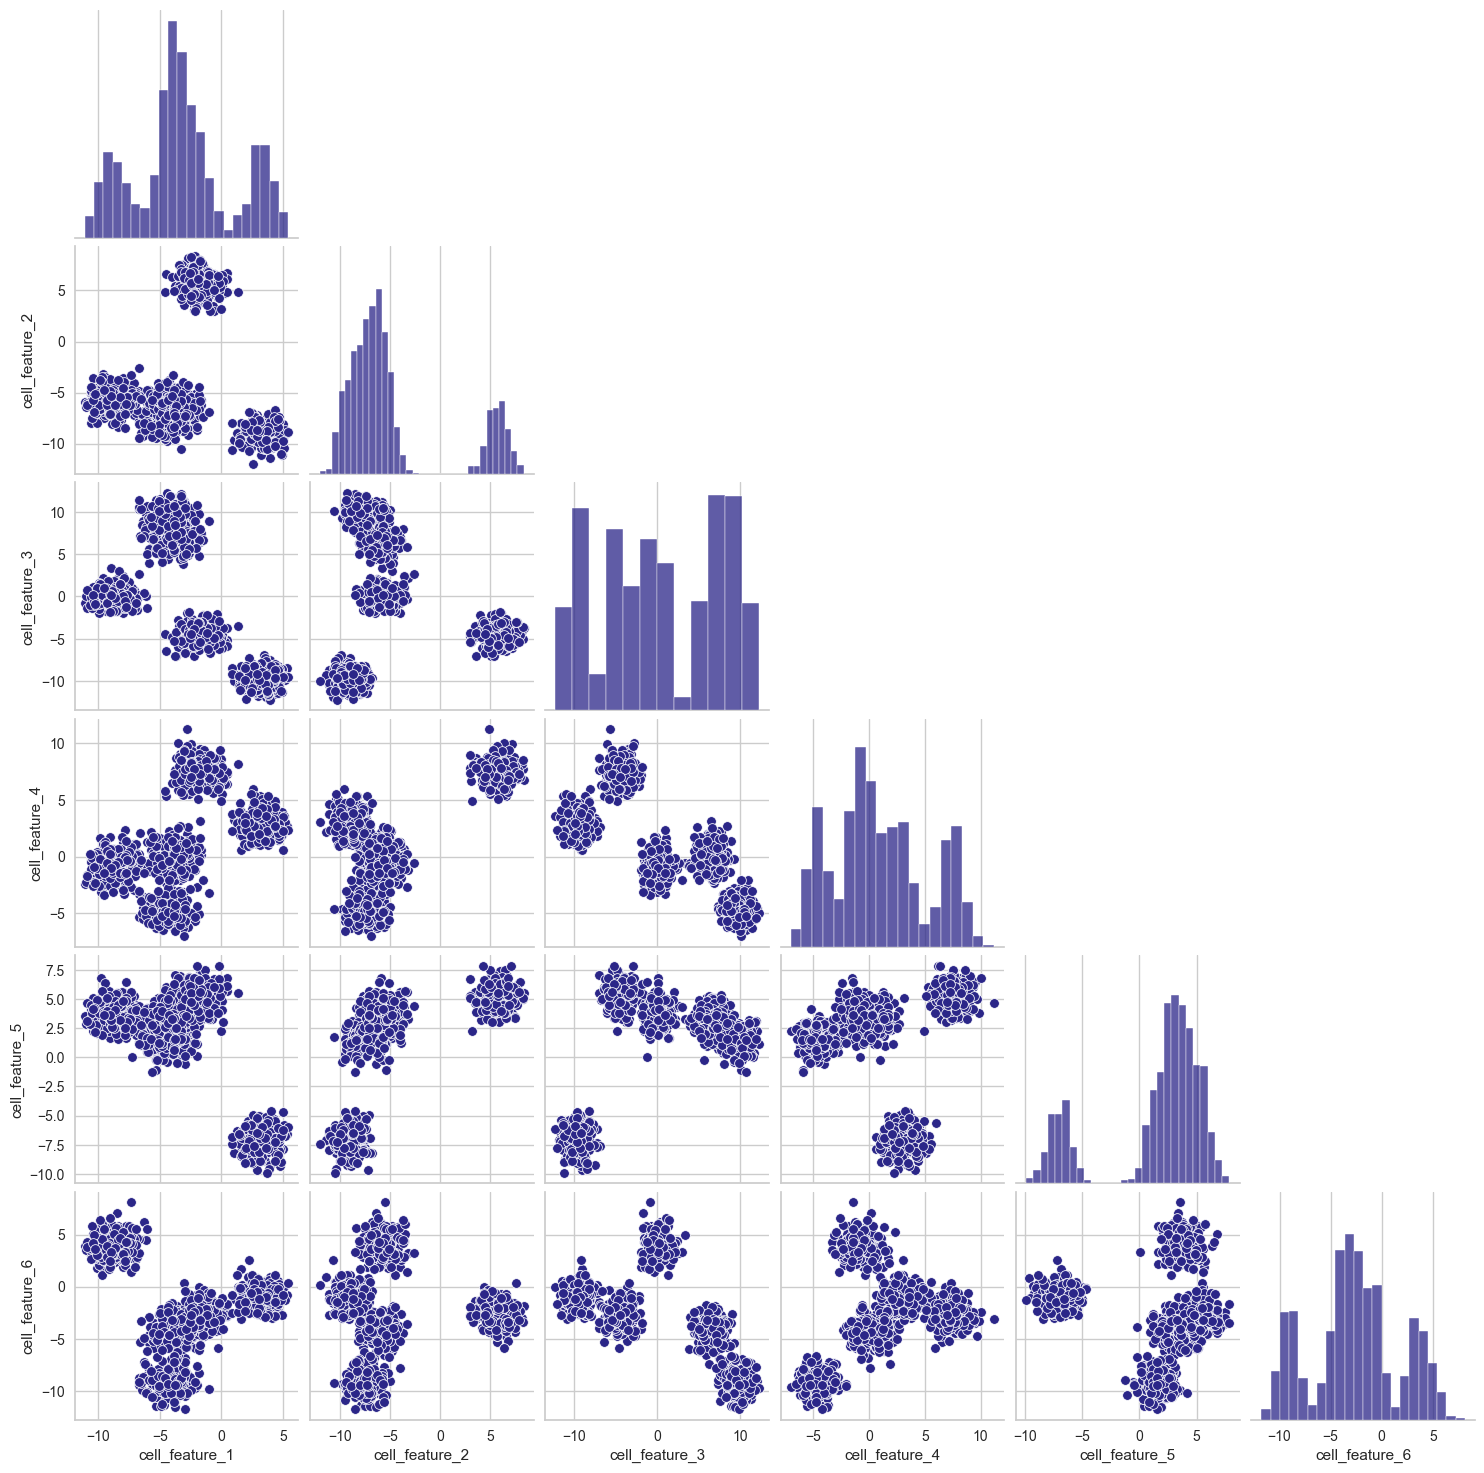

In [3]:
sns.pairplot(data, corner=True)
plt.show()


# Answer
While seaborn.pairplot can highlight areas where the data might naturally divide into clusters, especially if there are clear gaps or groupings in the pair-wise scatter plots, it's not always a reliable method for determining the exact number of clusters. For accurately identifying the number of clusters, more formal clustering analysis techniques (such as KMeans clustering along with the elbow method, silhouette analysis, or hierarchical clustering) are recommended. These methods analyze the data in its full multidimensional space and provide quantitative measures to help determine the optimal number of clusters. Each cluster in each level curve can potentially be different which is why we need a more analytical approach to determine clusters of this data.


### Q1.3 - <span style="color:red">[15]</span> - Cluster the dataframe `data` using `KMeans` with `k` in $[2, 3, 4, 5, 6]$. Plot inertia versus `k` as well as silhouette score versus `k` in separate plot windows. Solely relying on these two plots, what are the best **two** values that you would conclude for `k`? Why?

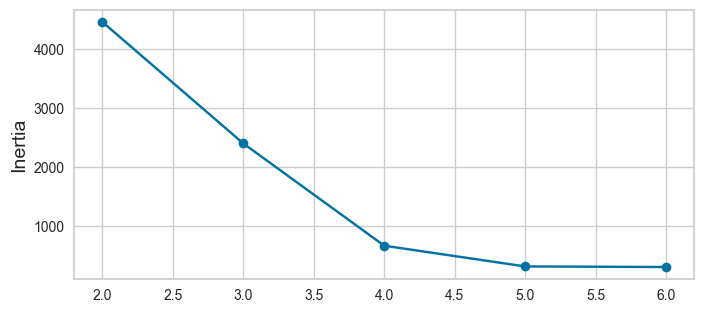

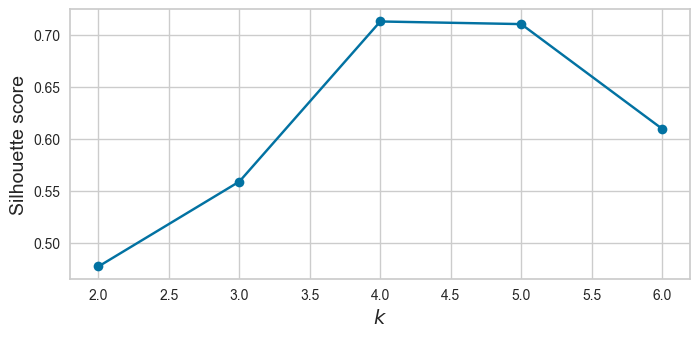

In [4]:
# scale data
scaler = prep.StandardScaler()
for feature in data.columns:
    data[[feature]] = scaler.fit_transform(data[[feature]])

cluster = [2, 3, 4, 5, 6]

kmeans_per_k = [KMeans(n_clusters=k, random_state=seed).fit(data) for k in cluster]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [
    metrics.silhouette_score(data, model.labels_) for model in kmeans_per_k
]

plt.figure(figsize=(8, 3.5))
plt.plot(cluster, inertias, "bo-")
plt.ylabel("Inertia", fontsize=14)
plt.show()

plt.figure(figsize=(8, 3.5))
plt.plot(cluster, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()


# Answer
Based on these two plots we can conclude that clustering with k=4 or k=5 would be our best option. This is because at 4 and 5 clusters inertia score plateaus and the silhouette scores are highest.


### Q1.4 - <span style="color:red">[20]</span> - Do the following steps on the dataframe `data`:
1. Plot the silhouette diagrams (*i.e.*, the stacked silhouette scores for clusters members) for the choices of `k` which you concluded in the previous question (*i.e.*, Q1.2).
2. Do a 2-component PCA and plot PC1 against PC2.
3. Do a 2-component t-SNE with a perplexity of 100 and plot the first embedding against the second embedding.
4. Interpret, in writing, the results of the previous 3 steps. What would be your final choice for the number of clusters (`k`)?

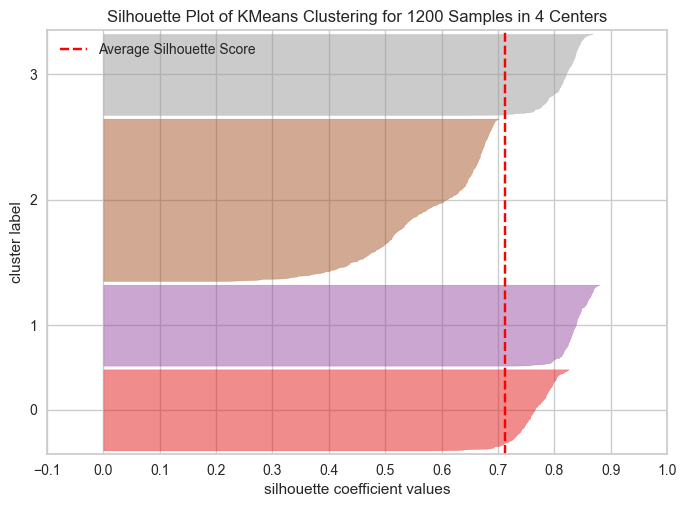

0.7129859572743572


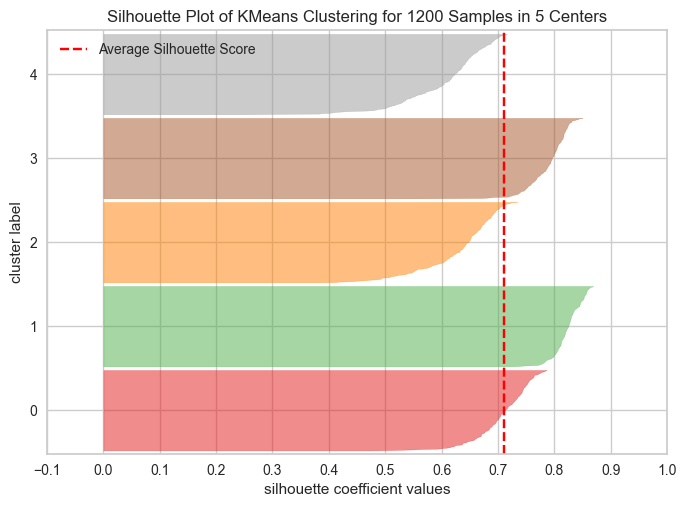

0.7104655289178058


In [5]:
cluster2 = [4, 5]

for k in cluster2:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(data)
    visualizer.show()
    print(metrics.silhouette_score(data, kmeans.labels_))
    plt.show()


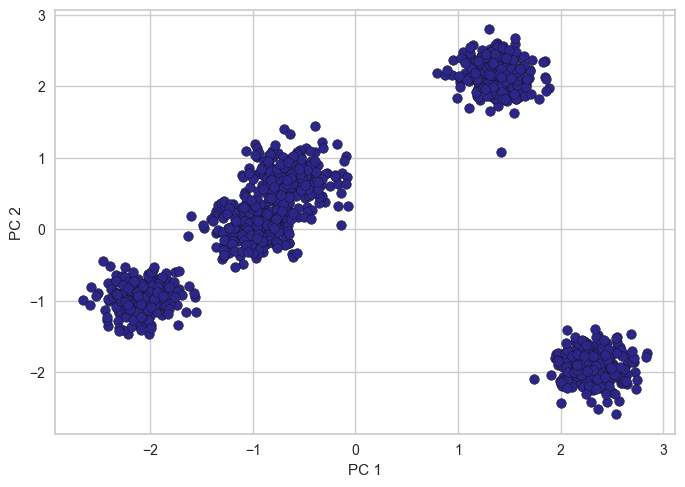

In [6]:
transformer1 = PCA(2, random_state=seed)
transformer1.fit(data)
X = transformer1.transform(data)
plt.scatter(X[:, 0], X[:, 1], edgecolor="k")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()


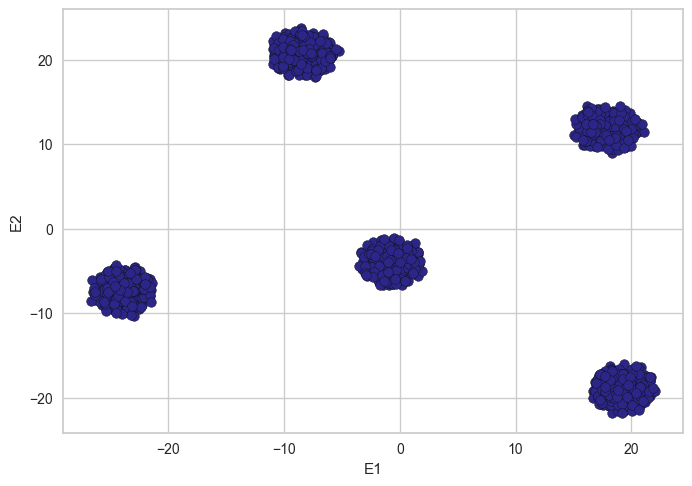

In [7]:
tSNEmapper = TSNE(n_components=2, perplexity=100.0, random_state=seed, n_jobs=-1)
TSNE_embedding = tSNEmapper.fit_transform(data)
plt.scatter(TSNE_embedding[:, 0], TSNE_embedding[:, 1], edgecolor="k")
plt.xlabel("E1")
plt.ylabel("E2")
plt.show()


# Answer
The silhouette plot shows that k=5 is better choice that k=4 because all clusters of k=5 pass the average silhouette score while the case is not true for k=4 where one cluster does not reach the average score.

The PCA shows that component 1 and 2 explain about 82% variance cumulatively and then plotted against each other the data forms 5 spherical clusters.

The TSNE analysis shows embedding 1 and 2 to cluster the data into 5 distinct and spaced out clusters.

All these analysis point to 5 clusters being the optimal number for this dataset with expected 5 types of cell in the data.


### Q1.5 - <span style="color:red">[30]</span> - Now that you have the number of clusters figured out, use the sample cells with known cell type to update the type of the "unknown" cells in the dataframe `dfc` (which you created in Q1.1) using decision boundaries defined over the t-SNE's first and second embeddings. The decision boundaries that you define could be of any geometric shape (*e.g.*, square) as long as they can perfectly isolate the clusters from each other. Also, plot these:
1.   scatter plot TSNE_embedding_0 vs TSNE_embedding_1, reflecting in a color-coded way, original known cells, unknown cells, and decision boundaries,
2.   scatter plot TSNE_embedding_0 vs TSNE_embedding_1 after updating the cell type of the unknown cells. Use different colors to distinguish the clusters,
3.   scatter plot "cell_feature_1" against "cell_feature_5" color coded by their updated "cell_type". This plot must have a legend indicating what color is referring to what type of cell.

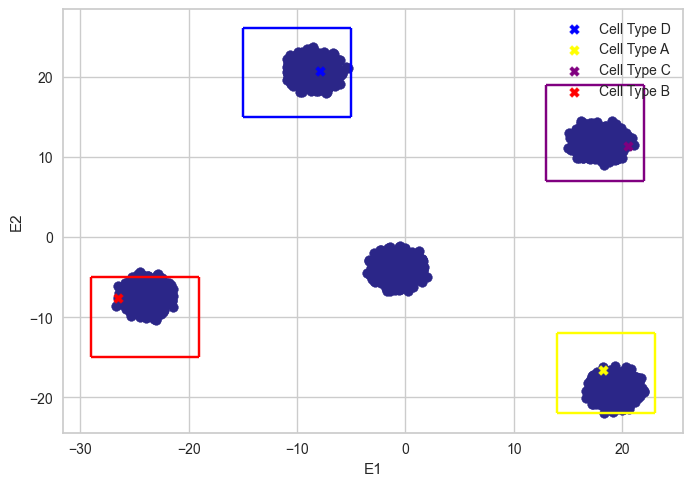


The members of the cluster in the middle remain unknown.



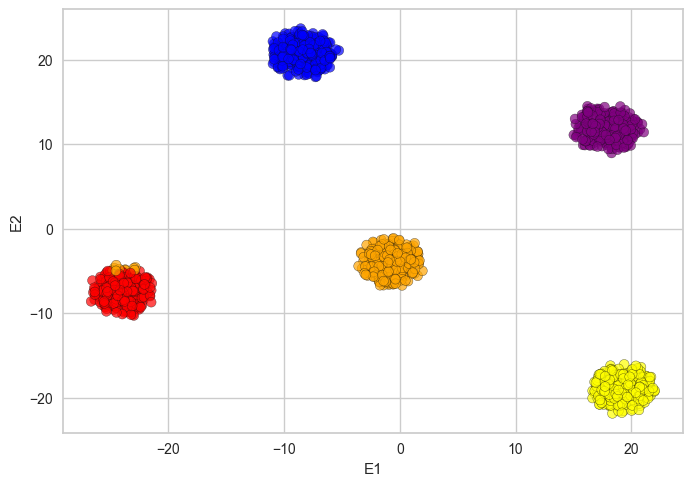

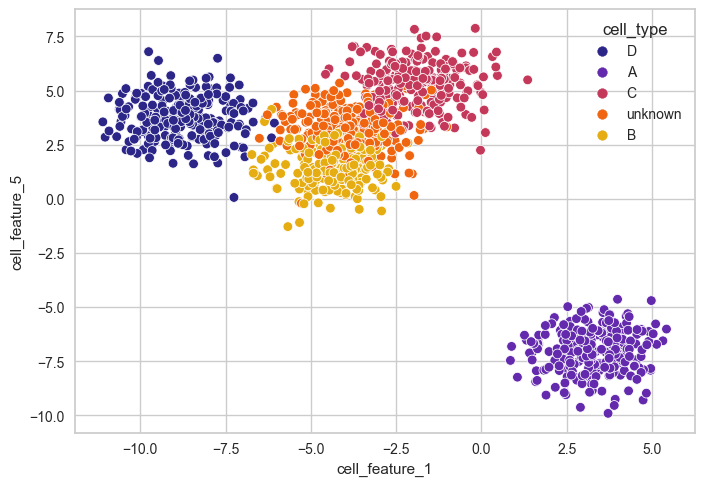

In [8]:
# plot TSNE_embedding_0 vs TSNE_embedding_1
plt.scatter(TSNE_embedding[:, 0], TSNE_embedding[:, 1])
plt.xlabel("E1")
plt.ylabel("E2")

# plot known cell types
known = dfc.loc[dfc.cell_type != "unknown"].index.values
plt.scatter(
    TSNE_embedding[known[0], 0],
    TSNE_embedding[known[0], 1],
    marker="X",
    c="blue",
    label="Cell Type " + dfc.cell_type.iloc[known[0]],
)
plt.scatter(
    TSNE_embedding[known[1], 0],
    TSNE_embedding[known[1], 1],
    marker="X",
    c="yellow",
    label="Cell Type " + dfc.cell_type.iloc[known[1]],
)
plt.scatter(
    TSNE_embedding[known[2], 0],
    TSNE_embedding[known[2], 1],
    marker="X",
    c="purple",
    label="Cell Type " + dfc.cell_type.iloc[known[2]],
)
plt.scatter(
    TSNE_embedding[known[3], 0],
    TSNE_embedding[known[3], 1],
    marker="X",
    c="red",
    label="Cell Type " + dfc.cell_type.iloc[known[3]],
)


# plot decision boundaries according to clusters seen
def my_db_plot(xmin, xmax, ymin, ymax, c):
    plt.hlines(y=ymin, xmin=xmin, xmax=xmax, colors=c)
    plt.hlines(y=ymax, xmin=xmin, xmax=xmax, colors=c)
    plt.vlines(x=xmin, ymin=ymin, ymax=ymax, colors=c)
    plt.vlines(x=xmax, ymin=ymin, ymax=ymax, colors=c)


# Cluster B decision boundary
cB_xmin, cB_xmax, cB_ymin, cB_ymax, cB_c = -29, -19, -15, -5, "red"
my_db_plot(cB_xmin, cB_xmax, cB_ymin, cB_ymax, cB_c)

# Cluster D decision boundary
cD_xmin, cD_xmax, cD_ymin, cD_ymax, cD_c = -15, -5, 15, 26, "blue"
my_db_plot(cD_xmin, cD_xmax, cD_ymin, cD_ymax, cD_c)

# Cluster C decision boundary
cC_xmin, cC_xmax, cC_ymin, cC_ymax, cC_c = 13, 22, 7, 19, "purple"
my_db_plot(cC_xmin, cC_xmax, cC_ymin, cC_ymax, cC_c)

# Cluster A decision boundary
cA_xmin, cA_xmax, cA_ymin, cA_ymax, cA_c = 14, 23, -22, -12, "yellow"
my_db_plot(cA_xmin, cA_xmax, cA_ymin, cA_ymax, cA_c)


plt.legend()
plt.show()
print("\nThe members of the cluster in the middle remain unknown.\n")


# labeling the unknown cells
def get_cluster_ids(TSNE_embedding, xmin, xmax, ymin, ymax):
    cluster_first_dim_id = np.argwhere(
        (TSNE_embedding[:, 0] > xmin) & (TSNE_embedding[:, 0] < xmax)
    )
    cluster_second_dim_id = np.argwhere(
        (TSNE_embedding[:, 1] > ymin) & (TSNE_embedding[:, 1] < ymax)
    )
    cluster_ids = np.intersect1d(cluster_first_dim_id, cluster_second_dim_id)
    return cluster_ids


cluster_A_ids = get_cluster_ids(TSNE_embedding, cA_xmin, cA_xmax, cA_ymin, cA_ymax)
cluster_B_ids = get_cluster_ids(TSNE_embedding, cB_xmin, cB_xmax, cB_ymin, cB_ymax)
cluster_C_ids = get_cluster_ids(TSNE_embedding, cC_xmin, cC_xmax, cC_ymin, cC_ymax)
cluster_D_ids = get_cluster_ids(TSNE_embedding, cD_xmin, cD_xmax, cD_ymin, cD_ymax)

final_df = dfc.copy()
final_df.cell_type.iloc[cluster_A_ids] = "A"
final_df.cell_type.iloc[cluster_B_ids] = "B"
final_df.cell_type.iloc[cluster_C_ids] = "C"
final_df.cell_type.iloc[cluster_D_ids] = "D"

##
colors = {"A": "yellow", "B": "red", "C": "purple", "D": "blue", "unknown": "orange"}
plt.scatter(
    TSNE_embedding[:, 0],
    TSNE_embedding[:, 1],
    edgecolor="k",
    alpha=0.7,
    c=final_df.cell_type.map(colors),
)
plt.xlabel("E1")
plt.ylabel("E2")
plt.show()

##
sns.scatterplot(data=final_df, x="cell_feature_1", y="cell_feature_5", hue="cell_type")
plt.show()


### Q1.6 - <span style="color:red">[15]</span> - This question in independent of Q1.5. This time, we want to update the cell type of the unknown cells using a different method. We have the number of clusters figured out in Q1.4 already. Use the sample cells with known cell type to update the type of the "unknown" cells in the dataframe `dfc` (which you created in Q1.1) using `kmeans.predict()`. Finally, scatter plot "cell_feature_1" against "cell_feature_5" color coded by their updated "cell_type". This plot must have a legend indicating what color is referring to what type of cell.

[0, 1, 3, 2]
['D', 'A', 'C', 'B']

Here is the concluding dictionary to use to map cell types:
{0: 'D', 2: 'A', 3: 'C', 4: 'B', 1: 'unknown'} 



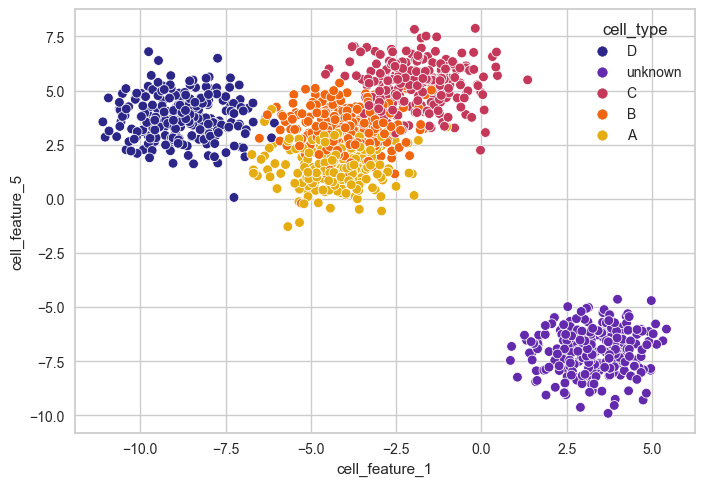

In [9]:
finalK = 5
kmeans = KMeans(n_clusters=finalK, random_state=seed)
kmeans.fit(data)

finalDF = dfc.copy()
finalDF["cell_type"] = kmeans.predict(data)

print(finalDF.iloc[dfc[dfc["cell_type"] != "unknown"]["cell_type"].index, -1].to_list())

print(dfc[dfc["cell_type"] != "unknown"]["cell_type"].to_list())

dic = {0: "D", 2: "A", 3: "C", 4: "B", 1: "unknown"}
print("\nHere is the concluding dictionary to use to map cell types:")
print(dic, "\n")

finalDF["cell_type"] = finalDF["cell_type"].map(dic)

sns.scatterplot(data=finalDF, x="cell_feature_1", y="cell_feature_5", hue="cell_type")
plt.show()
